In [1]:
# Import the necessary packages
#Third Party Packages
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import *
#from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
import time
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import plot_tree
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.ensemble import GradientBoostingRegressor


!pip install chempy
from chempy import Substance
from chempy.kinetics.ode import get_odesys
from chempy.kinetics.rates import MassAction

# Set seaborn style for better visualizations
sns.set(style="whitegrid")

# Define the SRM color mapping with the specified colors
srm_colors_custom = {
    1: "#f7e1a1",
    3: "#e9ad3f",
    5: "#d98416",
    9: "#b74d00",
    12: "#9f3400",
    16: "#811f00",
    22: "#5e0e00",
    29: "#410500",
    35: "#2f0200",
    65: "#0d0000"
}

# Convert the dictionary to a list of tuples (SRM value, color)
srm_color_list_custom = [(srm, color) for srm, color in srm_colors_custom.items()]

# Create a colormap from the SRM color list
srm_cmap_custom = mcolors.LinearSegmentedColormap.from_list("srm_cmap_custom", srm_color_list_custom)

# Register the colormap with matplotlib
plt.register_cmap(cmap=srm_cmap_custom)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.7/184.7 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.2/101.2 kB 14.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.9/107.9 kB 13.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 58.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 66.7 MB/s eta 0:00:00
  Created wheel for chempy: filename=chempy-0.9.0-py2.py3-none-any.whl size=210809 sha256=1cbff8951ef74bf886b7438b15fa3448391ed4510ba1ec7a5561ac7ba5d04680
  Stored in directory: /root/.cache/pip/wheels/67/6a/c8/0b931e3c1c6c4e620af52ab72afb8377af84307fc715d3d72b
  Created wheel for pyneqsys: filename=pyneqsys-0.5.7-py2.py3-none-any.whl size=27263 sha256=c366f29626d7ccd939ae58587f480d6e26fd68b116dcd5427b096a9041fa5d78
  Stored

<ipython-input-1-8c6c47005ec1>:63: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  plt.register_cmap(cmap=srm_cmap_custom)


In [2]:
# Load the dataset
beer_sample_set = pd.read_csv('sample_data/beer_sample_set.csv')

# Preview the dataset shape and first few rows
print("Dataset shape:", beer_sample_set.shape)
print("First few rows of the dataset:")
display(beer_sample_set.head())

Dataset shape: (250000, 20)
First few rows of the dataset:


,Batch_ID,Brew_Date,Beer_Style,SKU,Location,Fermentation_Time,Temperature,pH_Level,Gravity,Alcohol_Content,Bitterness,Color,Ingredient_Ratio,Volume_Produced,Total_Sales,Quality_Score,Brewhouse_Efficiency,Loss_During_Brewing,Loss_During_Fermentation,Loss_During_Bottling_Kegging
0,3755953,2020-05-14 08:34:44,Stout,Bottles,Electronic City,15,15.070090,4.944504,1.079232,5.104899,20,19,1:0.26:0.17,1562,3086.433606,6.366748,86.580666,4.210573,3.625139,1.665796
1,9574578,2023-10-15 04:29:22,Wheat Beer,Bottles,Rajajinagar,19,15.563835,5.403599,1.051625,5.075242,57,14,1:0.31:0.10,2163,2097.714127,6.895413,87.135717,3.440051,2.543174,3.659033
2,1765428,2022-08-20 06:12:42,Sour,Pints,HSR Layout,18,17.472288,4.660539,1.040395,4.864122,20,9,1:0.32:0.21,1774,3432.912254,6.964137,83.583678,2.660234,1.491750,1.724285
3,148284,2021-07-20 10:36:24,Ale,Cans,Marathahalli,14,19.652672,4.771273,1.070793,5.831239,20,19,1:0.32:0.24,918,18174.374992,6.683244,75.797874,1.171817,2.670990,4.800781
4,4716618,2022-03-19 22:46:08,Porter,Cans,HSR Layout,12,16.052576,5.377406,1.072926,5.343178,37,17,1:0.30:0.16,3983,11208.528234,6.955717,72.602524,3.181722,3.341978,1.026964


In [3]:
# Get summary
display(beer_sample_set.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 20 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Batch_ID                      250000 non-null  int64  
 1   Brew_Date                     250000 non-null  object 
 2   Beer_Style                    250000 non-null  object 
 3   SKU                           250000 non-null  object 
 4   Location                      250000 non-null  object 
 5   Fermentation_Time             250000 non-null  int64  
 6   Temperature                   250000 non-null  float64
 7   pH_Level                      250000 non-null  float64
 8   Gravity                       250000 non-null  float64
 9   Alcohol_Content               250000 non-null  float64
 10  Bitterness                    250000 non-null  int64  
 11  Color                         250000 non-null  int64  
 12  Ingredient_Ratio              250000 non-nul

None

In [4]:
# Create a copy of the DataFrame to avoid altering the original
beer_copy = beer_sample_set.copy()

In [5]:
beer_copy.describe().T

,count,mean,std,min,25%,50%,75%,max
Batch_ID,250000.0,4.999086e+06,2.890625e+06,2.000000,2.490954e+06,5.003928e+06,7.507267e+06,9.999999e+06
Fermentation_Time,250000.0,1.449914e+01,2.872375e+00,10.000000,1.200000e+01,1.500000e+01,1.700000e+01,1.900000e+01
Temperature,250000.0,2.000170e+01,2.888744e+00,15.000035,1.749655e+01,2.000299e+01,2.250576e+01,2.499994e+01
pH_Level,250000.0,5.000069e+00,2.885775e-01,4.500001,4.749905e+00,5.000492e+00,5.249833e+00,5.499981e+00
Gravity,250000.0,1.054970e+00,1.441660e-02,1.030000,1.042509e+00,1.054994e+00,1.067410e+00,1.080000e+00
Alcohol_Content,250000.0,5.249934e+00,4.325541e-01,4.500000,4.875885e+00,5.250218e+00,5.623876e+00,5.999988e+00
Bitterness,250000.0,3.951164e+01,1.155361e+01,20.000000,3.000000e+01,4.000000e+01,5.000000e+01,5.900000e+01
Color,250000.0,1.199132e+01,4.320796e+00,5.000000,8.000000e+00,1.200000e+01,1.600000e+01,1.900000e+01
Volume_Produced,250000.0,2.749398e+03,1.298396e+03,500.000000,1.626000e+03,2.748000e+03,3.873000e+03,4.999000e+03
Total_Sales,250000.0,1.049425e+04,5.482879e+03,1000.203514,5.750856e+03,1.048468e+04,1.523713e+04,1.999993e+04


In [6]:
# Compute the correlation matrix
corr_matrix = beer_copy.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


ValueError: could not convert string to float: '2020-05-14 08:34:44'

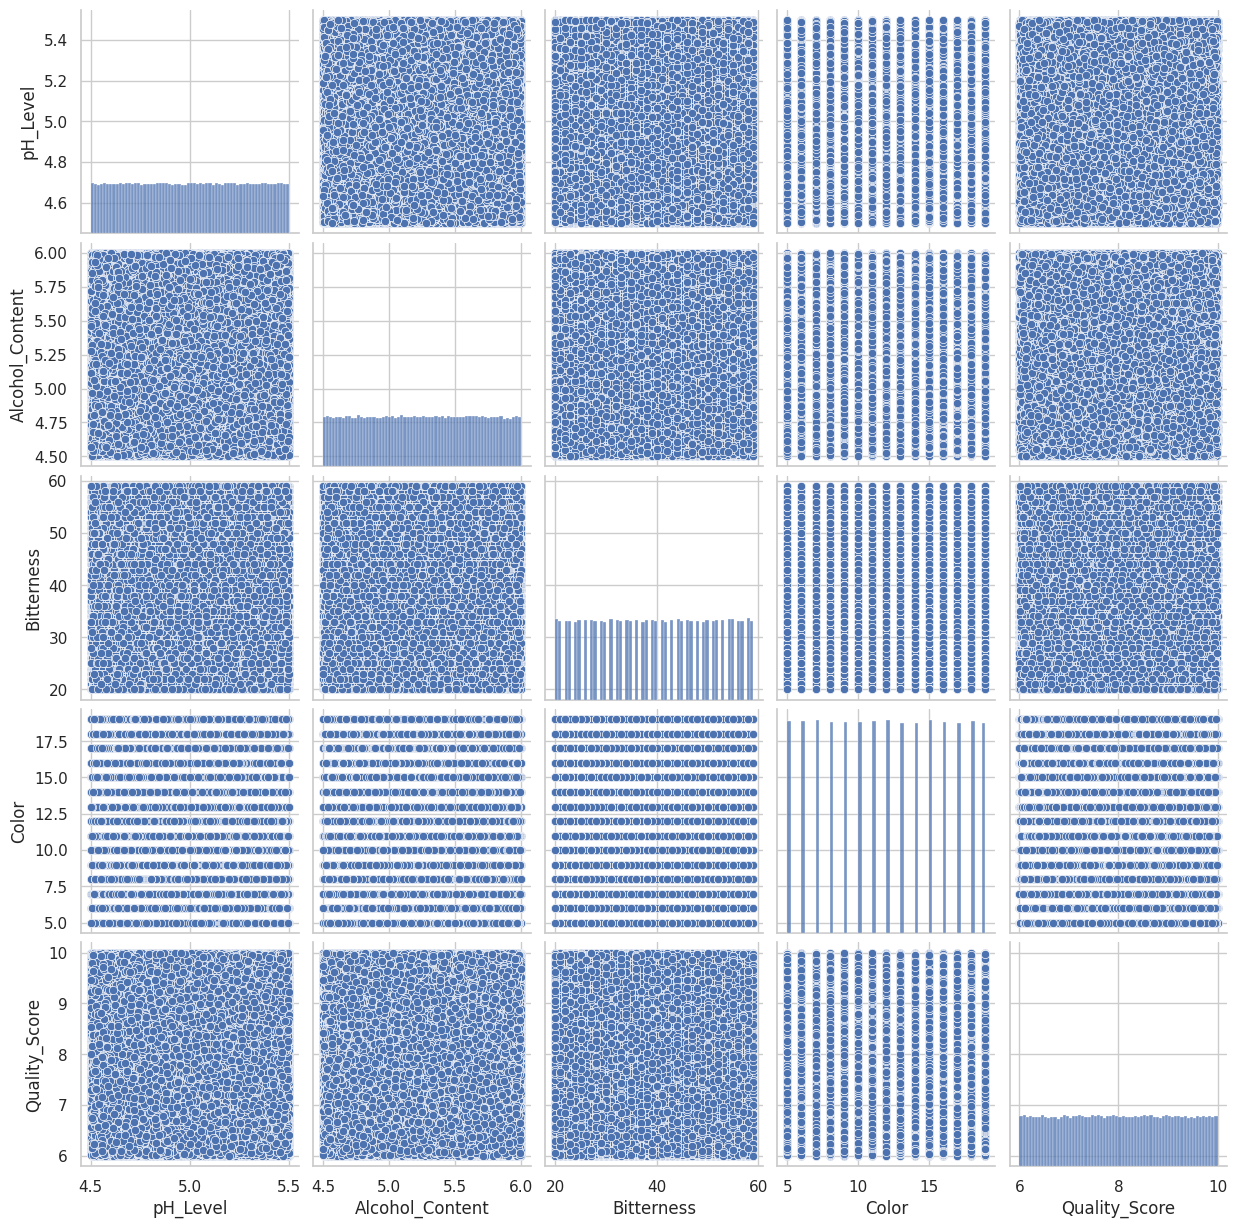

In [7]:
# Select relevant numerical columns for the pair plot
# Adjust the column names as per your DataFrame's column names
numeric_columns = ['pH_Level', 'Alcohol_Content', 'Bitterness', 'Color', 'Quality_Score']

# Plot the pair plot
sns.pairplot(beer_copy[numeric_columns])
plt.show()

In [8]:
# Define the columns relevant for feature engineering (features that contain chemistry dependent properties)
relevant_columns = ['pH_Level', 'Ingredient_Ratio', 'Fermentation_Time', 'Temperature',
                    'Alcohol_Content', 'Bitterness', 'Color', 'Quality_Score']
categorical_columns = ['Beer_Style']

# Create a subset of the data with relevant columns
beer_quality_predict = beer_copy[relevant_columns + categorical_columns].copy()

# Preview the subset of the data
print("Subset of the data with relevant columns:")
display(beer_quality_predict.head())

Subset of the data with relevant columns:


,pH_Level,Ingredient_Ratio,Fermentation_Time,Temperature,Alcohol_Content,Bitterness,Color,Quality_Score,Beer_Style
0,4.944504,1:0.26:0.17,15,15.070090,5.104899,20,19,6.366748,Stout
1,5.403599,1:0.31:0.10,19,15.563835,5.075242,57,14,6.895413,Wheat Beer
2,4.660539,1:0.32:0.21,18,17.472288,4.864122,20,9,6.964137,Sour
3,4.771273,1:0.32:0.24,14,19.652672,5.831239,20,19,6.683244,Ale
4,5.377406,1:0.30:0.16,12,16.052576,5.343178,37,17,6.955717,Porter


In [9]:
beer_quality_predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   pH_Level           250000 non-null  float64
 1   Ingredient_Ratio   250000 non-null  object 
 2   Fermentation_Time  250000 non-null  int64  
 3   Temperature        250000 non-null  float64
 4   Alcohol_Content    250000 non-null  float64
 5   Bitterness         250000 non-null  int64  
 6   Color              250000 non-null  int64  
 7   Quality_Score      250000 non-null  float64
 8   Beer_Style         250000 non-null  object 
dtypes: float64(4), int64(3), object(2)
memory usage: 17.2+ MB


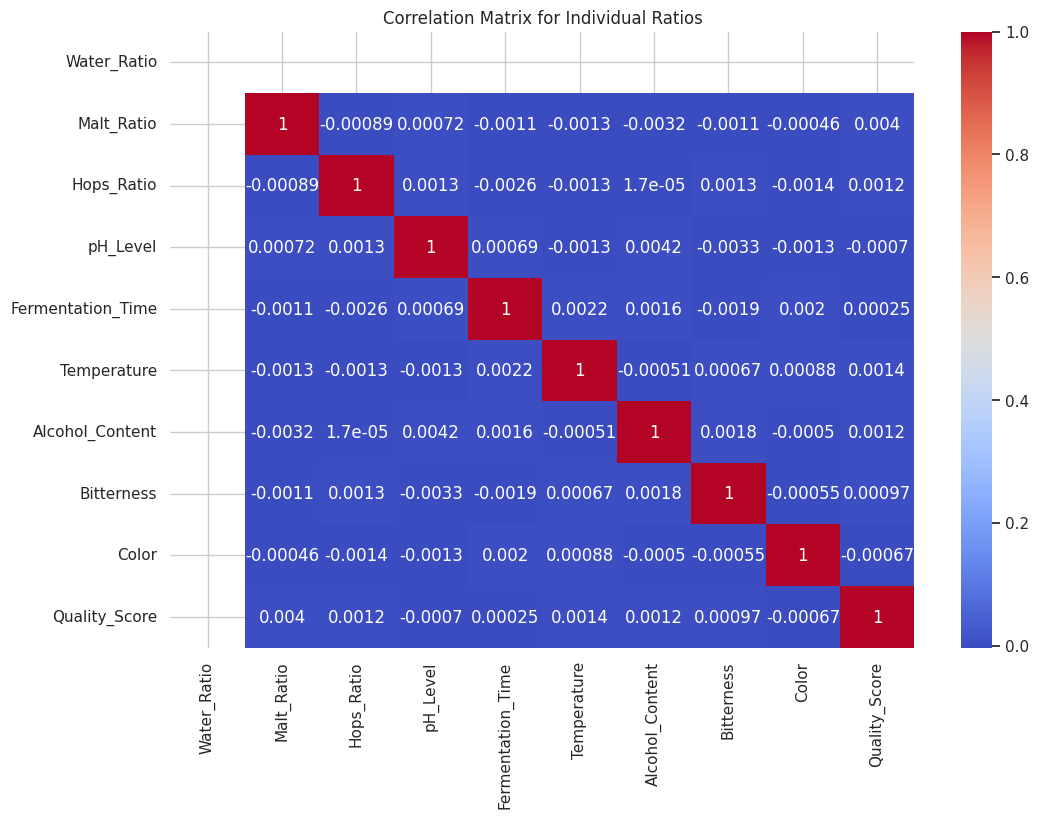

In [10]:
#Extract Individual Components
beer_quality_predict['Water_Ratio'] = 1.0
beer_quality_predict['Malt_Ratio'] = beer_quality_predict['Ingredient_Ratio'].apply(lambda x: float(x.split(':')[1]))
beer_quality_predict['Hops_Ratio'] = beer_quality_predict['Ingredient_Ratio'].apply(lambda x: float(x.split(':')[2]))

#Calculate Correlations:
correlation_matrix_indv = beer_quality_predict[['Water_Ratio', 'Malt_Ratio', 'Hops_Ratio', 'pH_Level', 'Fermentation_Time', 'Temperature',
                                'Alcohol_Content', 'Bitterness', 'Color', 'Quality_Score']].corr()

#Visualize Correlations
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_indv, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Individual Ratios')
plt.show()

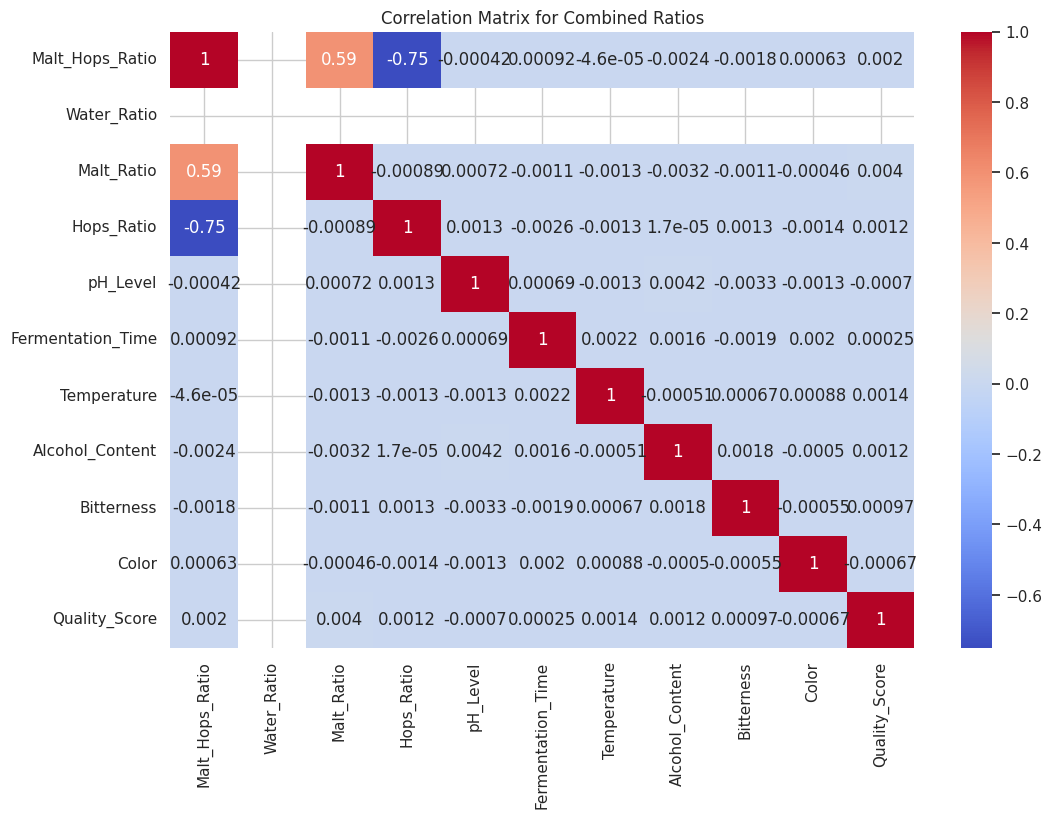

In [11]:
#Create Combined Ratio Feature
beer_quality_predict['Malt_Hops_Ratio'] = beer_quality_predict['Malt_Ratio'] / beer_quality_predict['Hops_Ratio']

#Calculate Correlations
combined_corr_matrix = beer_quality_predict[['Malt_Hops_Ratio','Water_Ratio', 'Malt_Ratio', 'Hops_Ratio', 'pH_Level', 'Fermentation_Time', 'Temperature',
                                'Alcohol_Content', 'Bitterness', 'Color', 'Quality_Score']].corr()

#Visualize Correlations
plt.figure(figsize=(12, 8))
sns.heatmap(combined_corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Combined Ratios')
plt.show()

In [12]:
# Function to infer malt type from color
def infer_malt(color):
    """
    Infers the type of malt based on the color of the beer.
    """
    if color < 10:
        return 'Barley'
    elif color < 20:
        return 'Wheat'
    elif color < 30:
        return 'Rye'
    else:
        return 'Oats'

# Function to infer hops type from bitterness
def infer_hops(bitterness):
    """
    Infers the type of hops based on the bitterness of the beer.
    """
    if bitterness > 40:
        return 'Bittering'
    elif bitterness > 20:
        return 'Dual Purpose'
    else:
        return 'Aroma'

#leaving out yeast because the traditional classification of ales and lagers doesn't fit well
#with my data
# Function to infer yeast type from temperature
#def infer_yeast(temperature):
#    """
#    Infers the type of yeast based on the fermentation temperature in Celsius.
#    """
#    if temperature > 15:
#        return 'Lager'
#    else:
#        return 'Ale'

# Apply feature engineering functions to infer malt, hops, and yeast types
beer_quality_predict['Malt_Type'] = beer_quality_predict['Color'].apply(infer_malt)
beer_quality_predict['Hops_Type'] = beer_quality_predict['Bitterness'].apply(infer_hops)
#beer_quality_predict['Yeast_Type'] = beer_quality_predict['Temperature'].apply(infer_yeast)

# Preview the engineered features
print("Data with engineered features (Malt_Type, Hops_Type):")
display(beer_quality_predict.head())

#Ales: 62-75 °F (17-24 °C)
#Lagers: 46-58 °F (8-14 °C) #assume dark lagers in this project
#Wheat and Belgian styles: 62-85 °F (17-29 °C), ales divided into these categories


Data with engineered features (Malt_Type, Hops_Type):


,pH_Level,Ingredient_Ratio,Fermentation_Time,Temperature,Alcohol_Content,Bitterness,Color,Quality_Score,Beer_Style,Water_Ratio,Malt_Ratio,Hops_Ratio,Malt_Hops_Ratio,Malt_Type,Hops_Type
0,4.944504,1:0.26:0.17,15,15.070090,5.104899,20,19,6.366748,Stout,1.0,0.26,0.17,1.529412,Wheat,Aroma
1,5.403599,1:0.31:0.10,19,15.563835,5.075242,57,14,6.895413,Wheat Beer,1.0,0.31,0.10,3.100000,Wheat,Bittering
2,4.660539,1:0.32:0.21,18,17.472288,4.864122,20,9,6.964137,Sour,1.0,0.32,0.21,1.523810,Barley,Aroma
3,4.771273,1:0.32:0.24,14,19.652672,5.831239,20,19,6.683244,Ale,1.0,0.32,0.24,1.333333,Wheat,Aroma
4,5.377406,1:0.30:0.16,12,16.052576,5.343178,37,17,6.955717,Porter,1.0,0.30,0.16,1.875000,Wheat,Dual Purpose


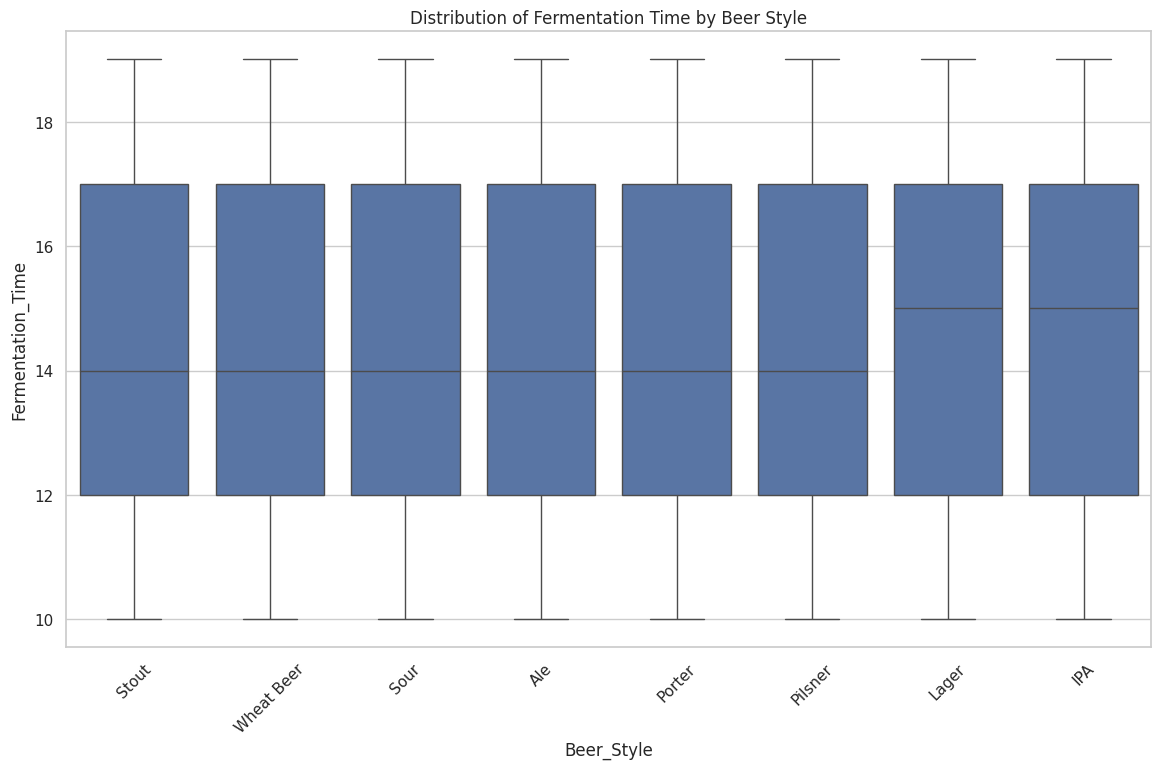

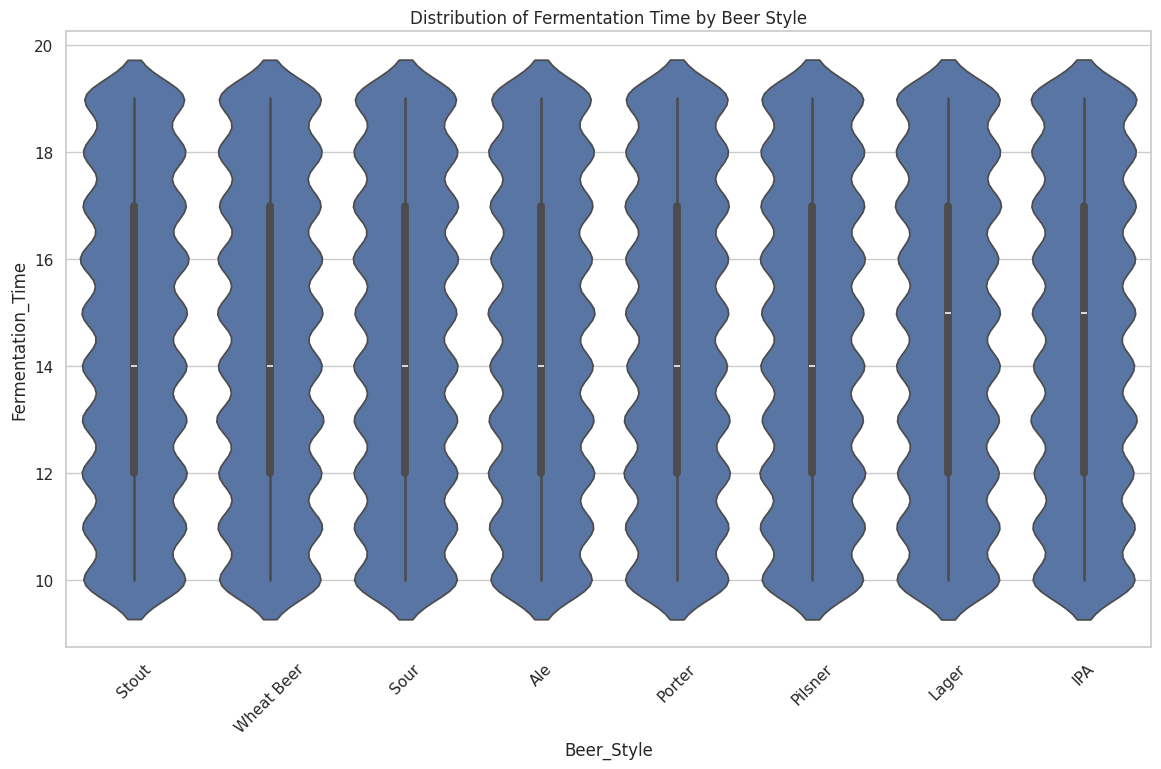

In [13]:
# Does Beer_Style feature distribute consistently into the
#Fermentation_Time feature?

# Extract relevant columns
ferment_style_comp = beer_quality_predict[['Beer_Style', 'Fermentation_Time']]

# Create a box plot
plt.figure(figsize=(14, 8))
sns.boxplot(x='Beer_Style', y='Fermentation_Time', data=ferment_style_comp)
plt.title('Distribution of Fermentation Time by Beer Style')
plt.xticks(rotation=45)
plt.show()

# Create a violin plot
plt.figure(figsize=(14, 8))
sns.violinplot(x='Beer_Style', y='Fermentation_Time', data=ferment_style_comp)
plt.title('Distribution of Fermentation Time by Beer Style')
plt.xticks(rotation=45)
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


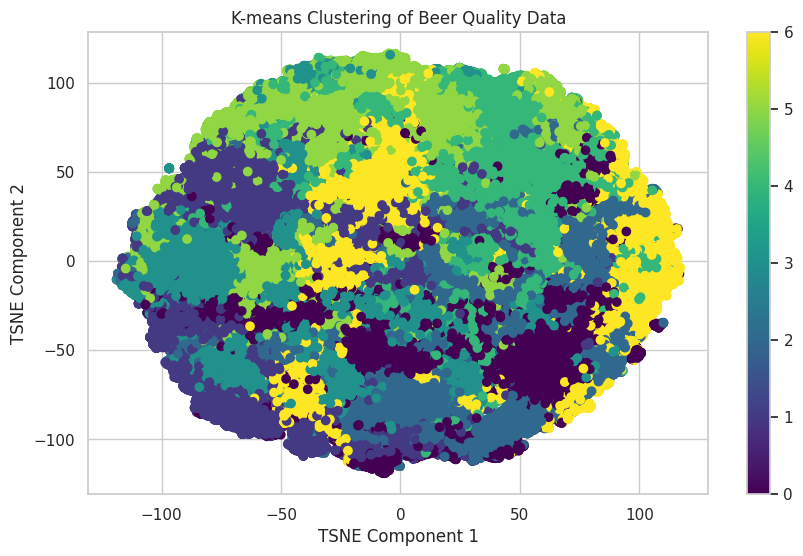

In [14]:
# Select relevant features for clustering
clustering_features = beer_quality_predict[['Temperature', 'Fermentation_Time', 'pH_Level', 'Alcohol_Content', 'Bitterness', 'Color']]

# Normalize the features
clustering_features_normalized = (clustering_features - clustering_features.mean()) / clustering_features.std()

# Apply KMeans clustering
num_clusters = 7  # Specify the number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
beer_quality_predict['Cluster'] = kmeans.fit_predict(clustering_features_normalized)

# Visualize the clusters using t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
clustering_features_tsne = tsne.fit_transform(clustering_features_normalized)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(clustering_features_tsne[:, 0], clustering_features_tsne[:, 1], c=beer_quality_predict['Cluster'], cmap='viridis')
plt.colorbar(scatter)
plt.title('K-means Clustering of Beer Quality Data')
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.show()


In [15]:
# Sample 2.5% of the rows with a seed for reproducibility
test_beer_quality_predict = beer_quality_predict.sample(frac=0.50, random_state=42)

In [16]:
# One-hot encode categorical variables for machine learning models
beer_encoded = pd.get_dummies(test_beer_quality_predict, columns=['Beer_Style', 'Malt_Type', 'Hops_Type'])

# Preview the one-hot encoded dataframe
print("One-hot encoded dataframe:")
display(beer_encoded.head())

One-hot encoded dataframe:


,pH_Level,Ingredient_Ratio,Fermentation_Time,Temperature,Alcohol_Content,Bitterness,Color,Quality_Score,Water_Ratio,Malt_Ratio,...,Beer_Style_Pilsner,Beer_Style_Porter,Beer_Style_Sour,Beer_Style_Stout,Beer_Style_Wheat Beer,Malt_Type_Barley,Malt_Type_Wheat,Hops_Type_Aroma,Hops_Type_Bittering,Hops_Type_Dual Purpose
38683,4.624166,1:0.33:0.19,18,23.544875,4.851446,45,5,7.438883,1.0,0.33,...,False,False,False,False,False,True,False,False,True,False
64939,5.088843,1:0.29:0.14,11,23.325096,4.747988,39,11,9.796537,1.0,0.29,...,False,False,False,False,False,False,True,False,False,True
3954,4.531028,1:0.29:0.25,19,18.303406,4.688581,48,13,8.722669,1.0,0.29,...,False,False,True,False,False,False,True,False,True,False
120374,5.052222,1:0.28:0.17,10,22.134268,4.600588,25,14,6.916323,1.0,0.28,...,False,False,False,False,False,False,True,False,False,True
172861,5.123969,1:0.34:0.14,15,20.809025,5.036298,24,13,6.971888,1.0,0.34,...,False,False,False,False,False,False,True,False,False,True


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

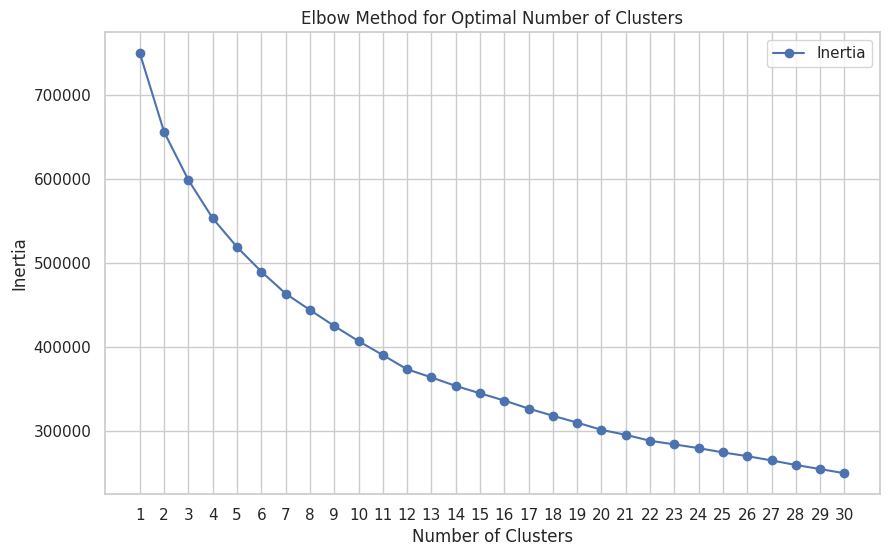

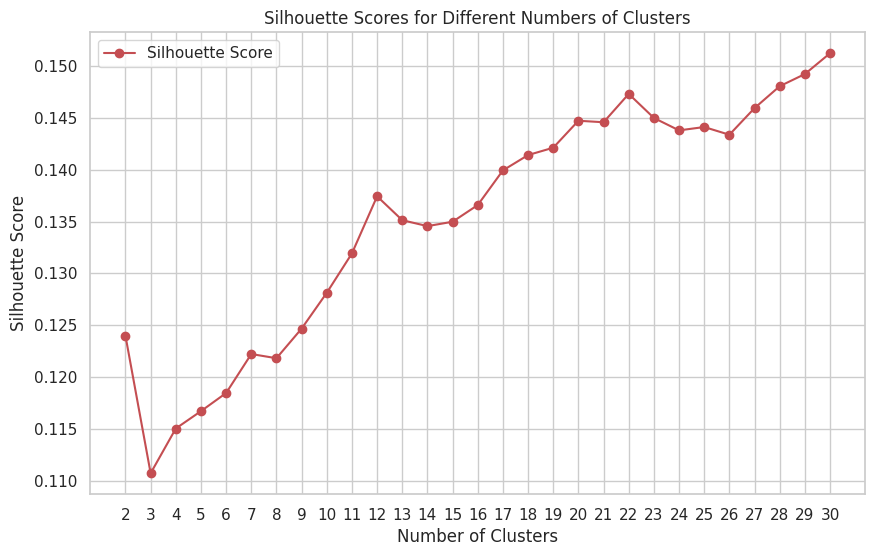

In [17]:
# Select relevant features for clustering
clustering_features = beer_encoded[['Temperature', 'Fermentation_Time', 'pH_Level', 'Alcohol_Content', 'Bitterness', 'Color']]

# Normalize the features
clustering_features_normalized = (clustering_features - clustering_features.mean()) / clustering_features.std()

# Define the range of clusters to test
min_clusters = 1
max_clusters = 30

# Store inertia and silhouette scores for different cluster sizes
inertia_values = []
silhouette_scores = []

# Iterate over the range of clusters
for k in range(min_clusters, max_clusters + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(clustering_features_normalized)
    inertia_values.append(kmeans.inertia_)

    # Silhouette score is only defined for k > 1
    if k > 1:
        silhouette_avg = silhouette_score(clustering_features_normalized, cluster_labels)
        silhouette_scores.append(silhouette_avg)

# Plot the inertia values to visualize the optimal number of clusters
plt.figure(figsize=(10, 6))
plt.plot(range(min_clusters, max_clusters + 1), inertia_values, marker='o', linestyle='-', color='b', label='Inertia')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xticks(range(min_clusters, max_clusters + 1))
plt.grid(True)
plt.legend()
plt.show()

# Plot the silhouette scores to further validate the optimal number of clusters
plt.figure(figsize=(10, 6))
plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o', linestyle='-', color='r', label='Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.xticks(range(2, max_clusters + 1))
plt.grid(True)
plt.legend()
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


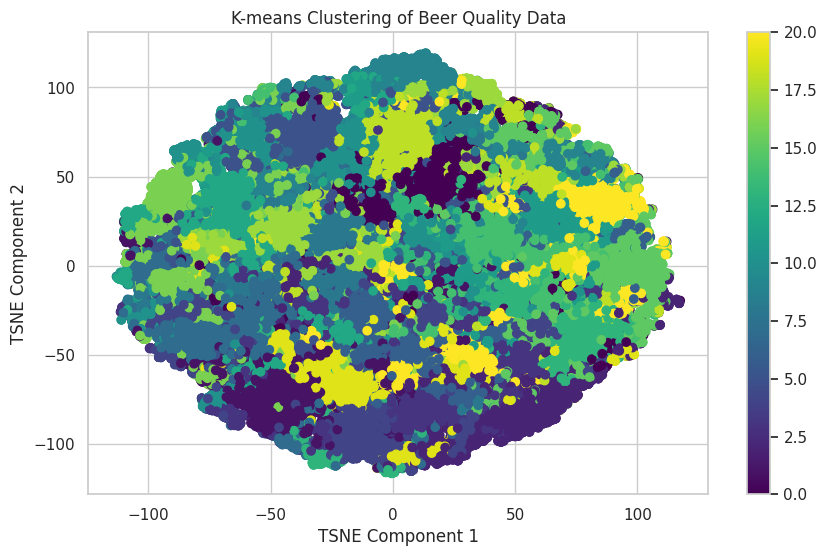

In [18]:
# Apply KMeans clustering
num_clusters = 21  # Specify the number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
beer_encoded['Cluster'] = kmeans.fit_predict(clustering_features_normalized)

# Visualize the clusters using t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
clustering_features_tsne = tsne.fit_transform(clustering_features_normalized)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(clustering_features_tsne[:, 0], clustering_features_tsne[:, 1], c=beer_encoded['Cluster'], cmap='viridis')
plt.colorbar(scatter)
plt.title('K-means Clustering of Beer Quality Data')
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.show()

In [ ]:
# Step 1: Calculate the average quality score for each cluster
cluster_order = beer_encoded.groupby('Cluster')['Quality_Score'].median().sort_values().index

# Step 2: Convert the 'Cluster' column to a categorical type with the sorted order
beer_encoded['Cluster'] = pd.Categorical(beer_encoded['Cluster'], categories=cluster_order, ordered=True)

# Step 3: Plot the box plots using the ordered clusters
features_to_plot = ['Quality_Score', 'Temperature', 'Fermentation_Time', 'pH_Level', 'Alcohol_Content', 'Bitterness', 'Color']

for feature in features_to_plot:
    plt.figure(figsize=(14, 10))
    sns.boxplot(x='Cluster', y=feature, data=beer_encoded, palette='viridis')
    plt.title(f'Distribution of {feature} by Cluster Ordered by Quality Score')
    plt.xlabel('Cluster')
    plt.ylabel(feature)
    plt.show()

In [20]:
beer_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 125000 entries, 38683 to 221577
Data columns (total 26 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   pH_Level                125000 non-null  float64 
 1   Ingredient_Ratio        125000 non-null  object  
 2   Fermentation_Time       125000 non-null  int64   
 3   Temperature             125000 non-null  float64 
 4   Alcohol_Content         125000 non-null  float64 
 5   Bitterness              125000 non-null  int64   
 6   Color                   125000 non-null  int64   
 7   Quality_Score           125000 non-null  float64 
 8   Water_Ratio             125000 non-null  float64 
 9   Malt_Ratio              125000 non-null  float64 
 10  Hops_Ratio              125000 non-null  float64 
 11  Malt_Hops_Ratio         125000 non-null  float64 
 12  Cluster                 125000 non-null  category
 13  Beer_Style_Ale          125000 non-null  bool    
 14  Beer_

In [21]:
# Extracting features (X_sample) and labels (y_sample)
X_sample = beer_encoded.loc[:, ['Malt_Ratio', 'Hops_Ratio', 'pH_Level', 'Fermentation_Time', 'Temperature',
                                'Alcohol_Content', 'Bitterness', 'Color', 'Beer_Style_Ale', 'Beer_Style_IPA', 'Beer_Style_Lager', 'Beer_Style_Pilsner', 'Beer_Style_Porter', 'Beer_Style_Sour', 'Beer_Style_Stout', 'Beer_Style_Wheat Beer', 'Malt_Type_Barley', 'Malt_Type_Wheat', 'Hops_Type_Aroma', 'Hops_Type_Bittering', 'Hops_Type_Dual Purpose']]
y_sample = beer_encoded.loc[:, 'Quality_Score']

# X_train and y_train will contain the training data, while X_test and y_test will contain the testing (holdout) data
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)

# Preview the shapes of the training and test sets
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (100000, 21)
Test set shape: (25000, 21)


In [ ]:
# Define the parameter grid
param_grid = {
    'n_estimators': [300, 600, 900],
    'max_depth': [None, 10, 40, 80],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Best estimator
best_rf_model = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred = best_rf_model.predict(X_test)
r2_score_best = best_rf_model.score(X_test, y_test)
print("R^2 score of the best model:", r2_score_best)

# Plot feature importances
plt.figure(figsize=(14, 8))
feature_importances.plot(kind='bar')
plt.title('Feature Importances from Random Forest')
plt.ylabel('Importance Score')
plt.show()


Fitting 3 folds for each of 216 candidates, totalling 648 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [1]:
# beer_encoded is the DataFrame and 'Quality_Score' is the target variable
X_sample = beer_encoded.loc[:, ['Malt_Ratio', 'Hops_Ratio', 'pH_Level', 'Fermentation_Time', 'Temperature',
                                'Alcohol_Content', 'Bitterness', 'Color', 'Beer_Style_Ale', 'Beer_Style_IPA',
                                'Beer_Style_Lager', 'Beer_Style_Pilsner', 'Beer_Style_Porter', 'Beer_Style_Sour',
                                'Beer_Style_Stout', 'Beer_Style_Wheat Beer', 'Malt_Type_Barley', 'Malt_Type_Wheat',
                                'Hops_Type_Aroma', 'Hops_Type_Bittering', 'Hops_Type_Dual Purpose']]
y_sample = beer_encoded.loc[:, 'Quality_Score']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
    'min_samples_split': [2, 5, 10]
}

# Initialize the Gradient Boosting Regressor
gbr = GradientBoostingRegressor(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Get the best model
best_gbr_model = grid_search.best_estimator_

# Predict on the test set
y_pred = best_gbr_model.predict(X_test)

# Evaluate the model
r2_score_best = r2_score(y_test, y_pred)
print("R^2 score of the best Gradient Boosting model:", r2_score_best)


NameError: name 'beer_encoded' is not defined

In [ ]:
# Define the columns relevant for feature engineering
relevant_columns = ['pH_Level', 'Ingredient_Ratio', 'Fermentation_Time', 'Temperature',
                    'Alcohol_Content', 'Bitterness', 'Color', 'Quality_Score']
categorical_columns = ['Beer_Style']

# Create a subset of the data with relevant columns
df_subset = df[relevant_columns + categorical_columns].copy()

# Preview the subset of the data
print("Subset of the data with relevant columns:")
print(df_subset.head())


In [ ]:
# Function to infer malt type from color
def infer_malt(color):
    """
    Infers the type of malt based on the color of the beer.
    """
    if color < 10:
        return 'Barley'
    elif color < 20:
        return 'Wheat'
    elif color < 30:
        return 'Rye'
    else:
        return 'Oats'

# Function to infer hops type from bitterness
def infer_hops(bitterness):
    """
    Infers the type of hops based on the bitterness of the beer.
    """
    if bitterness > 40:
        return 'Bittering'
    elif bitterness > 20:
        return 'Dual Purpose'
    else:
        return 'Aroma'

# Function to infer yeast type from temperature
def infer_yeast(temperature):
    """
    Infers the type of yeast based on the fermentation temperature.
    """
    return 'Lager' if temperature < 10 else 'Ale'

# Apply feature engineering functions to infer malt, hops, and yeast types
df_subset['Malt_Type'] = df_subset['Color'].apply(infer_malt)
df_subset['Hops_Type'] = df_subset['Bitterness'].apply(infer_hops)
df_subset['Yeast_Type'] = df_subset['Temperature'].apply(infer_yeast)

# Preview the engineered features
print("Data with engineered features (Malt_Type, Hops_Type, Yeast_Type):")
print(df_subset.head())


In [ ]:
# One-hot encode categorical variables for machine learning models
df_encoded = pd.get_dummies(df_subset, columns=['Beer_Style', 'Malt_Type', 'Hops_Type', 'Yeast_Type'])

# Preview the one-hot encoded dataframe
print("One-hot encoded dataframe:")
print(df_encoded.head())


In [ ]:
# Example of feature engineering
df['Yeast_Type'] = df.apply(lambda row: 'Lager' if row['Temperature'] < 10 else 'Ale', axis=1)
def infer_malt(color):
    if color < 10:
        return 'Barley'
    elif color < 20:
        return 'Wheat'
    elif color < 30:
        return 'Rye'
    else:
        return 'Oats'
df['Malt_Type'] = df['Color'].apply(infer_malt)
def infer_hops(bitterness):
    if bitterness > 40:
        return 'Bittering'
    elif bitterness > 20:
        return 'Dual Purpose'
    else:
        return 'Aroma'
df['Hops_Type'] = df['Bitterness'].apply(infer_hops)


In [ ]:
# Analyze optimal combinations for different beer styles
df_analysis = df[['pH_Level', 'Ingredient_Ratio', 'Fermentation_Time', 'Temperature', 'Alcohol_Content', 'Bitterness', 'Quality_Score', 'Yeast_Type', 'Malt_Type', 'Hops_Type']]
df_analysis = pd.get_dummies(df_analysis, columns=['Yeast_Type', 'Malt_Type', 'Hops_Type'])
correlation_matrix = df_analysis.corr()
print(correlation_matrix['Quality_Score'].sort_values(ascending=False))


In [ ]:
!pip install chempy


In [ ]:
from chempy import Substance
from chempy.kinetics.ode import get_odesys
from chempy.kinetics.rates import MassAction

# Define substances
maltose = Substance.from_formula('C12H22O11')
glucose = Substance.from_formula('C6H12O6')
ethanol = Substance.from_formula('C2H5OH')
co2 = Substance.from_formula('CO2')

# Define a simple reaction: Maltose -> 2 Glucose
reaction = MassAction({'C12H22O11': 1}, {'C6H12O6': 2}, 1.0)

# Get ODE system
odesys, extra = get_odesys([reaction])

# Initial concentrations (mol/L)
concs = {maltose: 1.0}

# Time points (seconds)
t = [0, 3600, 7200, 10800]

# Solve ODEs
result = odesys.integrate(t, concs)

print(result.plot(concs.keys()))


In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Assuming `df_analysis` is your feature-engineered DataFrame
X = df_analysis[['pH_Level', 'Ingredient_Ratio', 'Fermentation_Time', 'Temperature', 'Alcohol_Content', 'Bitterness']]
y = df_analysis['Quality_Score']

model = RandomForestRegressor()
model.fit(X, y)

# Evaluate the model
print(model.score(X, y))


Optimal Use Cases for ChemPy in Brewing Analysis
pH and Mineral Content:

Use ChemPy to model how different mineral compositions in water (calcium, magnesium) affect the pH during mashing and how this influences enzyme activity and starch conversion.
Fermentation Dynamics:

Model fermentation reactions to understand how different yeast strains (temperature and fermentation time) convert sugars to alcohol and CO2, impacting the final quality and flavor profile of the beer.
Ingredient Interactions:

Analyze how different ratios of malts and hops interact chemically during the brewing process and their cumulative impact on beer quality.
Integrating ChemPy with Machine Learning
For more advanced analysis, integrate ChemPy with machine learning tools like scikit-learn to predict quality scores based on chemical composition and brewing conditions:

Feature Engineering:

Use ChemPy to calculate chemical properties (e.g., reaction rates, equilibrium constants) and use these as features for machine learning models.


References:

1. https://brookstonbeerbulletin.com/thinking-about-beer-color/
2. https://homebrewing.org/pages/srm-beer-color-scale
3. https://www.kaggle.com/datasets/ankurnapa/brewery-operations-and-market-analysis-dataset/data
4. https://www.kaggle.com/code/diegoamd/brewery-dataset-eda-regression-and-clustering
5. https://blogs.cornell.edu/brewing/resources/
6. https://www.craftmasterstainless.com/blog/2023/11/21/a-guide-to-the-complex-chemistry-behind-beer-brewing
7. https://beaconhillsbrewhouse.wordpress.com/2011/09/18/water-chemistrys-influence-on-my-oktoberfest-beer/
8. https://spikebrewing.com/blogs/learn/primary-ingredients-for-brewing-beer
9. https://byo.com/article/understanding-residual-alkalinity-ph/
10. https://www.google.com/search?q=types+of+beer+yeast&sca_esv=f07dd38fdcfe8355&rlz=1C5CHFA_enUS504US504&ei=h0VwZt2lLuGeptQPxpuFiAE&ved=0ahUKEwidhcuH6uKGAxVhj4kEHcZNAREQ4dUDCBA&uact=5&oq=types+of+beer+yeast&gs_lp=Egxnd3Mtd2l6LXNlcnAaAhgDIhN0eXBlcyBvZiBiZWVyIHllYXN0MgsQABiABBiRAhiKBTIGEAAYFhgeMgYQABgWGB4yCRAAGBYYiwMYHjIJEAAYFhiLAxgeMgYQABgWGB4yBhAAGBYYHjILEAAYFhiLAxgeGA8yCRAAGBYYiwMYHjIJEAAYFhiLAxgeSOoVUJgEWLMTcAF4AZABAJgBjQGgAZsHqgEDNC41uAEDyAEA-AEBmAIKoAK9B8ICChAAGLADGNYEGEfCAgoQABiABBhDGIoFwgIOEAAYgAQYhgMYigUYiwPCAgsQABiABBiiBBiLA8ICBRAAGIAEwgIIEAAYFhgeGA_CAgsQABgWGAoYiwMYHsICCxAAGIAEGIYDGIoFwgIIEAAYgAQYogSYAwCIBgGQBgiSBwM1LjWgB5E8&sclient=gws-wiz-serp
11. https://www.micetgroup.com/the-business-competition-strategy-of-craft-brewery/
12. https://www.brewersassociation.org/directories/breweries/?location=United%20States&type=Regional
13. https://www.brewersassociation.org/programs/beer-food-program/
14. https://beersmith.com/blog/2016/02/11/the-sulfate-to-chloride-ratio-and-beer-bitterness/
15. https://www.nature.com/articles/s41467-024-46346-0
16. https://www.nature.com/scitable/topicpage/yeast-fermentation-and-the-making-of-beer-14372813/



